# Hierarchical Mixture Model

An example of a hierarchical mixture model

First we setup some data: We use two distributions, both normal, but take some fraction Q from the first distribution and 1-Q points from the second distribution.  We add in observation uncertainty and we have our data.  

In [98]:
import numpy as np
nu_true = 10.0
sigma_true = 1.0
out_mu_true = 2.0
out_sigma_true = 1.0
Q = 0.3
npts = 500
inliers = np.random.randn(int(npts*(1-Q))) * sigma_true + mu_true
outliers = np.random.randn(int(npts*(Q))) * out_sigma_true + out_mu_true
true = np.append(inliers, outliers)
yerr = np.ones(npts) * 2.5
yobs = true + np.random.randn(npts) * yerr

We can now plot our data.  Notice that the true distribution is formed of two well separated components, but when observation uncertainty is included this is not at all obvious.

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


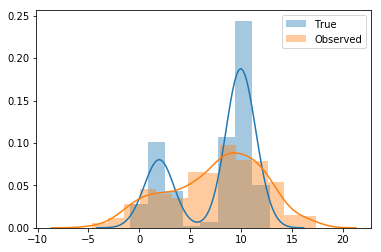

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.distplot(true, label='True')
ax = sns.distplot(yobs, label='Observed')
ax.legend()
plt.show()

We can now setup our stan model.  This follows a similar path to problem 1 but this time we have two means and two sigmas.  

The true $y$ should be consistent with the observed $y$ given the observation uncertainty:

$y_{\rm true} \sim \mathcal{N}(y_{\rm obs}, y_{\rm err})$.

We place some hyperpriors on the hyperparameters:

$\mu \sim \mathcal{N}(7.5, 10.0)$,

$\sigma \sim {\rm Lognormal}(\log(1.0), 0.3)$,

$Q \sim \mathcal{N}(0.5, 0.2)$,

$Q \sim \mathcal{U}(0, 1)$,

We make a transformed parameter that is the difference between the two means of the distribution.  We place a prior on this difference of:

${\rm diff} \sim {\rm Lognormal}(\log(0.5), 1.0)$.

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


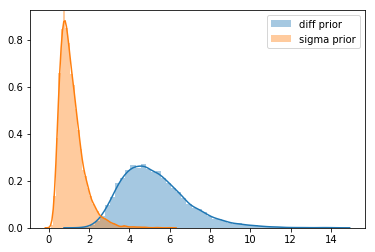

In [100]:
fig, ax = plt.subplots()
diff = np.random.lognormal(np.log(5.0), 0.3, 10000)
sigmad = np.random.lognormal(np.log(1.0), 0.5, 10000)
ax = sns.distplot(diff, label='diff prior')
ax = sns.distplot(sigmad, label='sigma prior')
ax.legend()

Finally we deal with the mixture part of the model.  The $Q$ parameter controls the mixture.  The likelihood function is then:

$p(y \, | \, Q, \mu, \sigma) = \prod_{i=1}^{N} \, Q \, \mathcal{N}(y_{i} \, | \, \mu_{1}, \sigma_{1}) \, + \, (1 - Q) \, \mathcal{N}(y_{i} \, | \, \mu_{2}, \sigma_{2})$.

In stan we can use the log_mix function to take care of this for us.

In [78]:
code = '''
data {
    int N;
    real y[N];
    real yerr[N];
}
parameters {
    real mu[2];
    real<lower =0.001> sigma[2];
    real<lower = 0, upper = 13.8> y_true[N];
    real<lower = 0, upper = 1> theta;    
}
transformed parameters {
    real diff;
    diff = mu[2] - mu[1];
}
model {   
    y ~ normal(y_true, yerr); // Measurement uncertainty
    mu ~ normal(7.5, 10);
    sigma ~ lognormal(log(1.0), 0.5);
    theta ~ normal(0.5, 0.2);
    diff ~ lognormal(log(5.0), 0.3);
    for (n in 1:N)
        target += log_mix(theta,
                     normal_lpdf(y_true[n] | mu[1], sigma[1]),
                     normal_lpdf(y_true[n] | mu[2], sigma[2]));
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fccbe56bda277032b7459ec961b879fa NOW.


In [101]:
nchains = 4
data = {'N': npts,
       'y': yobs,
       'yerr': yerr}
fit = sm.sampling(data=data, iter=30000, chains=nchains)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


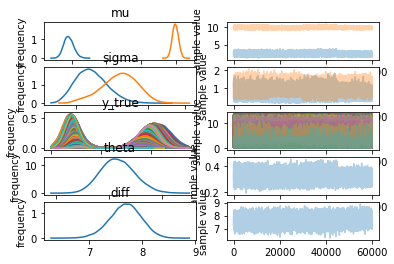

In [102]:
fit.plot()
plt.show()

In [103]:
print(fit)

Inference for Stan model: anon_model_fccbe56bda277032b7459ec961b879fa.
4 chains, each with iter=30000; warmup=15000; thin=1; 
post-warmup draws per chain=15000, total post-warmup draws=60000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]          2.3    0.05   0.36   1.64   2.05   2.28   2.53   3.04     55   1.08
mu[1]         9.98    0.03   0.22   9.55   9.83   9.98  10.13  10.42     59   1.08
sigma[0]      0.71    0.02   0.22   0.33   0.56    0.7   0.85   1.18    171   1.03
sigma[1]       1.1    0.03   0.25   0.56   0.94   1.11   1.28   1.55     79   1.06
y_true[0]    10.28  4.2e-3   1.02   8.24   9.62  10.27  10.94  12.35  60000    1.0
y_true[1]     9.53    0.08    1.6   3.54   9.01   9.75  10.42  11.73    439   1.01
y_true[2]    10.27  4.2e-3   1.04   8.22   9.61  10.27  10.93  12.33  60000    1.0
y_true[3]    10.23  4.2e-3   1.02   8.18   9.57  10.23  10.89  12.24  60000    1.0
y_true[4]    10.26  4.3e-3   1.05   8.21    9.6  10.26  10.9

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


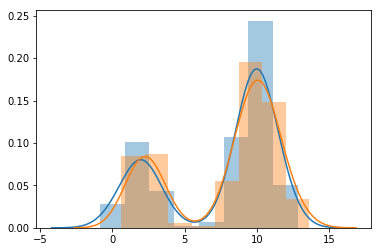

In [104]:
sns.distplot(true)
sns.distplot(fit['y_true'][1000, :])


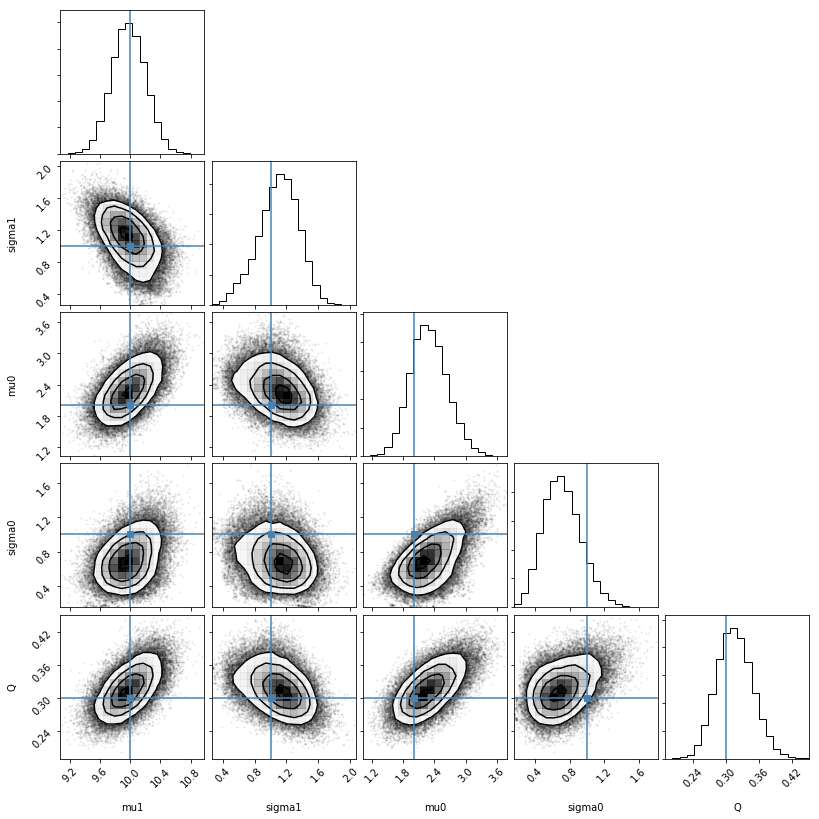

In [110]:
import corner
data = np.vstack([fit['mu'][:, 1], fit['sigma'][:, 1], fit['mu'][:, 0], fit['sigma'][:, 0], fit['theta']]).T
corner.corner(data, labels=['mu1', 'sigma1', 'mu0', 'sigma0', 'Q'], truths=[nu_true, sigma_true, out_mu_true, out_sigma_true, Q])
plt.show()